#Run Simulation
##Imports and help functions

In [24]:
import datetime
import time as time_module

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pymc3 as pm
import theano.tensor as tt
import theano
import matplotlib


confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(deaths_url, sep=',')
path_to_save = 'figures/'


In [25]:
def delay_cases(new_I_t, len_new_I_t, len_new_cases_obs , delay, delay_arr):
    """
    Delays the input new_I_t by delay and return and array with length len_new_cases_obs
    The initial delay of the output is set by delay_arr. 
    
    Take care that delay is smaller or equal than delay_arr, otherwise zeros are 
    returned, which could potentially lead to errors

    Also assure that len_new_I_t is larger then len(new_cases_obs)-delay, otherwise it 
    means that the simulated data is not long enough to be fitted to the data.
    """
    delay_mat = make_delay_matrix(n_rows=len_new_I_t, 
                                  n_columns=len_new_cases_obs, initial_delay=delay_arr)
    inferred_cases = interpolate(new_I_t, delay, delay_mat)
    return inferred_cases 

def make_delay_matrix(n_rows, n_columns, initial_delay=0):
    """
    Has in each entry the delay between the input with size n_rows and the output
    with size n_columns
    """
    size = max(n_rows, n_columns)
    mat = np.zeros((size, size))
    for i in range(size):
        diagonal = np.ones(size-i)*(initial_delay + i)
        mat += np.diag(diagonal, i)
    for i in range(1, size):
        diagonal = np.ones(size-i)*(initial_delay - i)
        mat += np.diag(diagonal, -i)
    return mat[:n_rows, :n_columns]

def interpolate(array, delay, delay_matrix):
    interp_matrix = tt.maximum(1-tt.abs_(delay_matrix - delay), 0)
    interpolation = tt.dot(array,interp_matrix)
    return interpolation

def smooth_step_function(λ_begin, λ_end, t_begin, t_end, t_total):
    t = np.arange(t_total)
    return tt.clip((t-t_begin)/(t_end-t_begin), 0,1)*(λ_end - λ_begin) + λ_begin


format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])

def get_data_germany(begin_date, end_date):
    date_formatted_begin = format_date(begin_date)
    date_formatted_end = format_date(end_date)
    cases_obs =  np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                          date_formatted_begin:date_formatted_end])[0]
    return cases_obs
                        
def get_last_date():
    last_date = confirmed_cases.columns[-1]
    month, day, year = map(int,last_date.split('/'))
    return datetime.datetime(year+2000, month, day)


##Define Model

In [26]:
date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = get_last_date()
#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
cases_obs = get_data_germany(date_data_begin, date_data_end)


diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days

#cases_obs = np.concatenate([np.nan*np.ones(diff_data_sim), cases_obs])
print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))

# ------------------------------------------------------------------------------ #
# model setup and training
# ------------------------------------------------------------------------------ #
np.random.seed(0)

def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all



with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.HalfCauchy('I_begin', beta=100)

    # fraction of people that are newly infected each day
    λ_0 = pm.Lognormal("λ_0", mu=np.log(0.4), sigma=0.5)
    λ_1 = pm.Lognormal("λ_1", mu=np.log(0.2), sigma=0.5)
    λ_2 = pm.Lognormal("λ_2", mu=np.log(1/8), sigma=0.2)
    λ_3 = pm.Lognormal("λ_3", mu=np.log((1/8)/2), sigma=0.2)


    # set the start dates of the two periods
    date_mild_dist_begin = datetime.datetime(2020,3,9)
    prior_day_mild_dist_begin = (date_mild_dist_begin - date_begin_sim).days
    mild_dist_begin = pm.Normal('mild_dist_begin', mu=prior_day_mild_dist_begin,
                                sigma = 3)
    date_strong_dist_begin = datetime.datetime(2020,3,16)
    prior_day_strong_dist_begin = (date_strong_dist_begin - date_begin_sim).days
    strong_dist_begin = pm.Normal('strong_dist_begin', mu=prior_day_strong_dist_begin,
                                  sigma = 1)
    
    date_3rd_scenario_begin = datetime.datetime(2020,3,23)
    prior_day_3rd_scenario_begin = (date_3rd_scenario_begin - date_begin_sim).days
    third_scenario_begin = pm.Normal('third_scenario_begin', mu=prior_day_3rd_scenario_begin,
                                  sigma = 1)

    # transient time
    transient_mild = pm.Lognormal('transient_mild', mu=np.log(3), sigma=0.3)
    transient_strong = pm.Lognormal('transient_strong', mu=np.log(3), sigma=0.3)
    transient_third_scenario = pm.Lognormal('transient_third_scenario', mu=np.log(3), sigma=0.3)


    # build the time-dependent spreading rate
    λ_tmp1 = smooth_step_function(λ_begin = 0, λ_end = 1, t_begin = mild_dist_begin, 
                                  t_end = mild_dist_begin + transient_mild, 
                                  t_total=num_days_sim)*(λ_1 - λ_0)
    λ_tmp2 = smooth_step_function(λ_begin = 0, λ_end = 1, t_begin = strong_dist_begin, 
                                  t_end = strong_dist_begin + transient_strong, 
                                  t_total=num_days_sim)*(λ_2 - λ_1)
    λ_tmp3 = smooth_step_function(λ_begin = 0, λ_end = 1, t_begin = third_scenario_begin , 
                                t_end = third_scenario_begin  + transient_third_scenario, 
                                t_total=num_days_sim)*(λ_3 - λ_2)
    
    # Set which steps are used, can be changed later (because of theano.shared)
    use_2nd_step = theano.shared(1.0)
    use_3rd_step = theano.shared(0.0)
    
    λ_t = λ_0 + λ_tmp1 + λ_tmp2*use_2nd_step +  λ_tmp3*use_3rd_step

    # fraction of people that recover each day, recovery rate mu
    μ = pm.Lognormal('μ', mu=np.log(1/8), sigma=0.2)

    # delay in days between contracting the disease and being recorded
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)

    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy("σ_obs", beta=10)

    N_germany = 83e6

    # -------------------------------------------------------------------------- #
    # training the model with loaded data
    # -------------------------------------------------------------------------- #


    S_begin = N_germany - I_begin
    S_past, I_past, new_I_past = SIR_model(λ=λ_t, μ=μ, 
                                            S_begin=S_begin, I_begin=I_begin,
                                            N=N_germany)
    new_cases_obs = np.diff(cases_obs)
    new_cases_inferred = delay_cases(new_I_past, 
                                     len_new_I_t=num_days_sim, 
                                     len_new_cases_obs=num_days_sim-diff_data_sim, 
                                     delay=delay, delay_arr=diff_data_sim)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model
    pm.StudentT(
        "obs",
        nu=4,
        mu=new_cases_inferred[:num_days_data],
        sigma=(new_cases_inferred[:num_days_data])**0.5 * σ_obs,
        observed=new_cases_obs)  
    
    λ_t = pm.Deterministic('λ_t', λ_t)
    new_cases_past = pm.Deterministic('new_cases', new_cases_inferred)
    

Cases yesterday (2020-04-05T00:00:00): 100123 and day before yesterday: 96092


##Sampling

In [27]:
with model:
    use_2nd_step.set_value(1.0)
    use_3rd_step.set_value(0.0)
    trace_2steps = pm.sample(draws=1500, tune=1000, chains=6, cores=6, init='adapt_diag')
    use_2nd_step.set_value(0.0)
    use_3rd_step.set_value(0.0)
    trace_1step = pm.sample(draws=1500, tune=1000, chains=6, cores=6, init='adapt_diag')
    use_2nd_step.set_value(1.0)
    use_3rd_step.set_value(1.0)
    trace_3steps = pm.sample(draws=1500, tune=1000, chains=6, cores=6, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [σ_obs, delay, μ, transient_third_scenario, transient_strong, transient_mild, third_scenario_begin, strong_dist_begin, mild_dist_begin, λ_3, λ_2, λ_1, λ_0, I_begin]
Sampling 6 chains, 0 divergences: 100%|██████████| 15000/15000 [05:56<00:00, 42.09draws/s]
The acceptance probability does not match the target. It is 0.8830660161068065, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [σ_obs, delay, μ, transient_third_scenario, transient_strong, transient_mild, third_scenario_begin, strong_dist_begin, mild_dist_begin, λ_3, λ_2, λ_1, λ_0, I_begin]
Sampling 6 chains, 18 divergences: 100%|██████████| 15000/15000 [07:40<00:00, 32.60draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 div

#Plotting 

Plots with data from 2020-03-01 to 2020-04-05
[737486. 737496.]


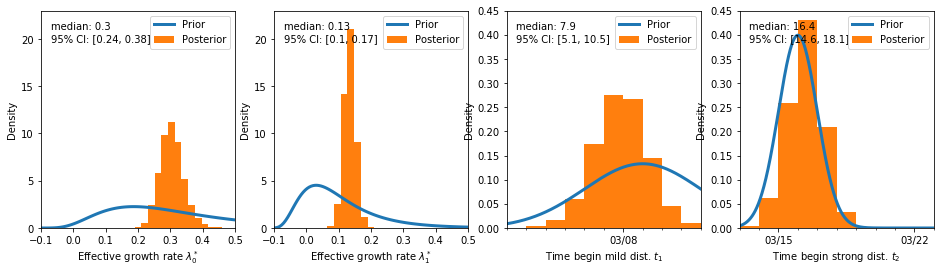

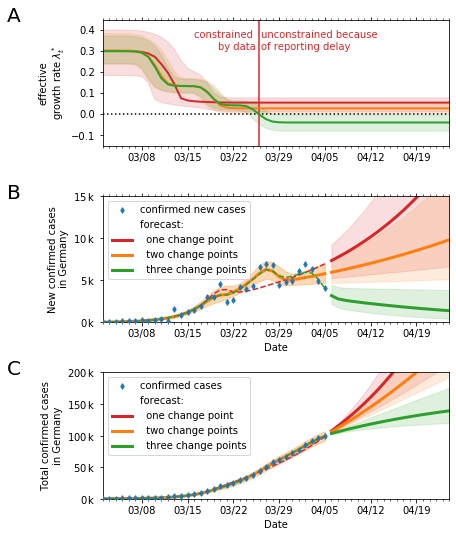

In [28]:
def truncate_number(number, precision):
    number = round(number, ndigits = precision)
    #number = round(number - number%(10**(-precision)),10)
    if precision == 0:
        number = int(round(number))
    return str(number)

def print_median_CI(arr, prec = 2):
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = f_trunc(np.percentile(arr, q=2.5)), f_trunc(np.percentile(arr, q=97.5))
    #print('The 95% CI of {} is [{:.3f} , {:.3f}] with a median of {:.3f}'.format(label, med, perc1, perc2))
    return 'median: {}\n95% CI: [{}, {}]'.format(med, perc1, perc2)
def conv_time_to_mpl_dates(arr):
    return matplotlib.dates.date2num([datetime.timedelta(days=float(date)) + date_begin_sim for date in arr])

print("Plots with data from {} to {}".format(date_data_begin.date().isoformat(), date_data_end.date().isoformat()))

trace = trace_2steps
posterior = [trace_1step, trace_2steps, trace_3steps]


fig, axes = plt.subplots(1,4, figsize=(16, 4))
#plt.locator_params(nbins=4)
pos_letter = (-0.2, 1)


limit_λ = (-0.1,0.5)
bins_λ=np.linspace(*limit_λ, 30)


ax = axes[0]
ax.hist(trace.λ_0 - trace.μ, bins=bins_λ, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_λ, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x+1/8, scale=0.4, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_λ)
ax.set_ylabel('Density')
ax.set_xlabel('Effective growth rate $\lambda_0^*$')
text = print_median_CI(trace.λ_0 - trace.μ, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes)
ax.legend(loc='upper right')
ax.set_ylim(0,23)


ax = axes[1]
ax.hist(trace.λ_1 - trace.μ, bins=bins_λ, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_λ, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x+1/8, scale=0.2, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_λ)
ax.set_ylabel('Density')
ax.set_xlabel('Effective growth rate $\lambda_1^*$')
text = print_median_CI(trace.λ_1 - trace.μ, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes)
ax.legend(loc='upper right')
ax.set_ylim(0,23)



diff_to_0 = num_days_data + diff_data_sim 


dates_mild = conv_time_to_mpl_dates(trace.mild_dist_begin)

ax = axes[2]
limits = matplotlib.dates.date2num([datetime.date(2020,3,2), datetime.date(2020,3,12)])
bins = np.arange(limits[0], limits[1]+1)
ax.hist(dates_mild, bins=bins, density=True, color='tab:orange',
        label='Posterior')
#limits = ax.get_xlim()
x = np.linspace(*limits, num=1000)
ax.plot(x, scipy.stats.norm.pdf(x, loc=conv_time_to_mpl_dates([prior_day_mild_dist_begin])[0], scale=3), 
        label='Prior',color='tab:blue', linewidth=3)
ax.set_xlim(limits[0], limits[1])
ax.set_ylabel('Density')
ax.set_xlabel('Time begin mild dist. $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes)
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_ylim(0,0.45)
print(limits)

ax = axes[3]
dates_strong = conv_time_to_mpl_dates(trace.strong_dist_begin)
limits = matplotlib.dates.date2num([datetime.date(2020,3,13), datetime.date(2020,3,23)])
bins = np.arange(limits[0], limits[1]+1)
ax.hist(dates_strong, bins=bins, density=True, color='tab:orange',
        label='Posterior')
#limits = ax.get_xlim()
x = np.linspace(*limits, num=1000)
ax.plot(x, scipy.stats.norm.pdf(x, loc=conv_time_to_mpl_dates([prior_day_strong_dist_begin])[0], scale=1), 
        label='Prior',color='tab:blue', linewidth=3)
ax.set_xlim(limits[0], limits[1])
ax.set_ylabel('Density')
ax.set_xlabel('Time begin strong dist. $t_2$')
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes)
ax.legend(loc='upper right')
#ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_ylim(0,0.45)
ax.set_xlim(limits[0], limits[1])



plt.savefig(path_to_save + 'summary_distributions.png', dpi=300)
plt.savefig(path_to_save + 'summary_distributions.pdf', dpi=300)


fig, axes = plt.subplots(3,1, figsize=(6.5,7.5), gridspec_kw={'height_ratios': [2, 2,2]})

colors  = ['tab:red', 'tab:orange', 'tab:green']
legends = ['forecast: ', '  one change point', '  two change points',  '  three change points']

ax = axes[1]

time1 = np.arange(-len(cases_obs)+2, 1)
mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
start_date = mpl_dates[0]
diff_cases =np.diff(cases_obs)
ax.plot(mpl_dates, diff_cases, 'd', label='confirmed new cases', markersize=4, color='tab:blue', 
            zorder=5)
#ax.plot(mpl_dates, diff_cases, 'd', markersize=4, color='tab:blue', 
#            zorder=6)

new_cases_past = trace.new_cases[:,:num_days_data]
percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(new_cases_past, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(new_cases_past, axis=0),color='tab:orange', linewidth=3)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')

ax.plot([],[], label=legends[0], alpha=0)
for trace_scen, color, legend in zip(posterior, colors, legends[1:]):
    new_cases_past = trace_scen.new_cases[:,:num_days_data]
    ax.plot(mpl_dates, np.median(new_cases_past, axis=0),'--',color=color, linewidth=1.5)

    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    end_date = mpl_dates_fut[-10]
    cases_future = trace_scen['new_cases'][:, num_days_data:].T
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*diff_cases[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
    np.percentile(cases_future, q=2.5, axis=-1),
    np.percentile(cases_future, q=97.5, axis=-1),
    )

    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label=legend)
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.15, color=color)
    #ax.fill_between(mpl_dates, np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
    #            alpha=0.2, color=color)

ax.set_xlabel('Date')
ax.set_ylabel('New confirmed cases\nin Germany')
ax.legend(loc='upper left')
ax.set_ylim(0, 15_000)
# ax.legend(loc='lower left')
#ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
#ax.set_xlim(-28, 14)
ax.locator_params(axis="y", nbins=4)
func_format = lambda num, _: "${:.0f}\,$k".format(num/1_000)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_xlim(start_date, end_date)
ax.text(-0.275, 0.98, "B", transform=ax.transAxes, size=20)
ax.xaxis.set_ticks_position('both')


ax=axes[2]

time1 = np.arange(-len(cases_obs)+2, 1)
mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
ax.plot(mpl_dates, cases_obs[1:], 'd', label='confirmed cases', markersize=4, color='tab:blue', 
            zorder=5)
#ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, color='tab:blue', 
#            zorder=6)

cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(cum_cases, axis=0),color='tab:orange', linewidth=3)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')

ax.plot([],[], label=legends[0], alpha=0)
for trace_scen, color, legend in zip(posterior, colors, legends[1:]):
    new_cases_past = trace_scen.new_cases[:,:num_days_data]
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),'--',color=color, linewidth=1.5)

    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    cases_future = np.cumsum(trace_scen['new_cases'][:, num_days_data:].T, axis=0) + cases_obs[-1]
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*cases_obs[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
        np.percentile(cases_future, q=2.5, axis=-1),
        np.percentile(cases_future, q=97.5, axis=-1),
    )
    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label=legend)
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.15, color=color)
    #ax.fill_between(mpl_dates, np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
    #                alpha=0.2, color=color)

ax.set_xlabel('Date')
ax.set_ylabel('Total confirmed cases\nin Germany')
ax.legend(loc='upper left')
ax.set_ylim(0, 200_000)
# ax.legend(loc='lower left')
#ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
#ax.set_xlim(-28, 14)
ax.locator_params(axis="y", nbins=4)
func_format = lambda num, _: "${:.0f}\,$k".format(num/1_000)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_xlim(start_date, end_date)
ax.text(-0.275, 0.98, "C", transform=ax.transAxes, size=20)


ax = axes[0]

time = np.arange(-diff_to_0+1, -diff_to_0+num_days_sim+1)

for trace_scen, color in zip(posterior, colors):

    λ_t = trace_scen['λ_t'][:, :]
    μ = trace_scen['μ'][:,None]
    mpl_dates = conv_time_to_mpl_dates(time) + diff_data_sim + num_days_data

    ax.plot(mpl_dates, np.median(λ_t-μ, axis=0), color=color, linewidth=2)
    ax.fill_between(mpl_dates, np.percentile(λ_t-μ , q=2.5, axis=0),np.percentile(λ_t-μ, q=97.5, axis=0), alpha=0.15,
                    color=color)
    #ax.fill_between(mpl_dates, np.percentile(λ_t , q=12.5, axis=0),np.percentile(λ_t, q=87.5, axis=0), alpha=0.2,
    #                color=color)

ax.set_ylabel('effective\ngrowth rate $\lambda_t^*$')
# ax.set_xlabel("days from now")
# ax.legend(loc='lower left')
ax.set_xticks([-28, -21, -14, -7, 0, 7, 14, 21, 28])
#ax.set_xlim(-28, 14)
ax.set_ylim(-0.15, 0.45)
#ax.set_yticks([-0.2, 0, 0.2])
#ax.set_aspect(15, adjustable="box")
ax.hlines(0,start_date, end_date, linestyles=':')
delay = matplotlib.dates.date2num(date_data_end) - np.percentile(trace_2steps.delay, q=75)
ax.vlines(delay,-10, 10, linestyles='-', colors=['tab:red'])
#ax.legend()
ax.text(delay+0.4, 0.4, 'unconstrained because\nof reporting delay', color='tab:red', verticalalignment='top')
ax.text(delay-0.4, 0.4, 'constrained \nby data', color='tab:red',horizontalalignment='right', verticalalignment='top')
ax.text(-0.275, 0.98, "A", transform=ax.transAxes, size=20)
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_xlim(start_date, end_date)
ax.xaxis.set_ticks_position('both')

fig.subplots_adjust(hspace=-0.90)
plt.tight_layout()
plt.savefig(path_to_save + 'summary_forecast.png', dpi=300)
plt.savefig(path_to_save + 'summary_forecast.pdf', dpi=300)

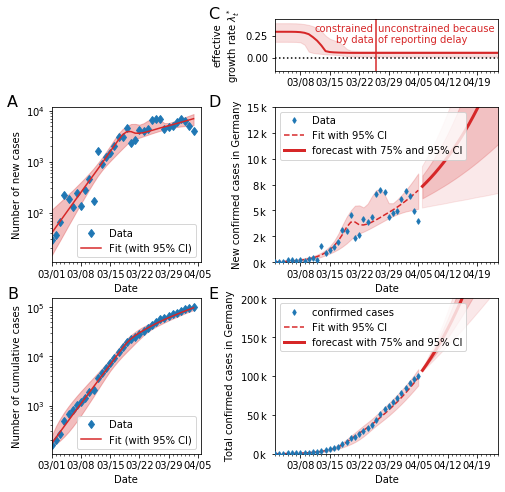

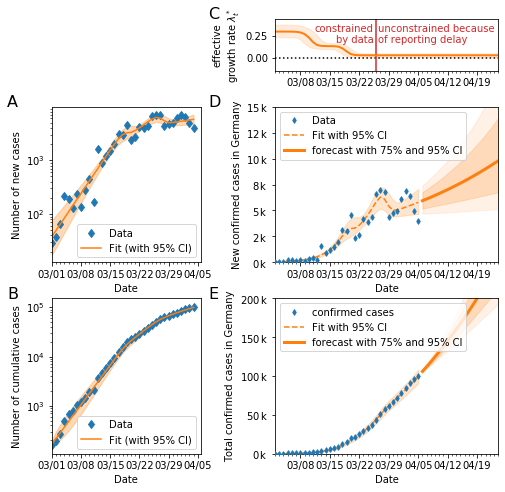

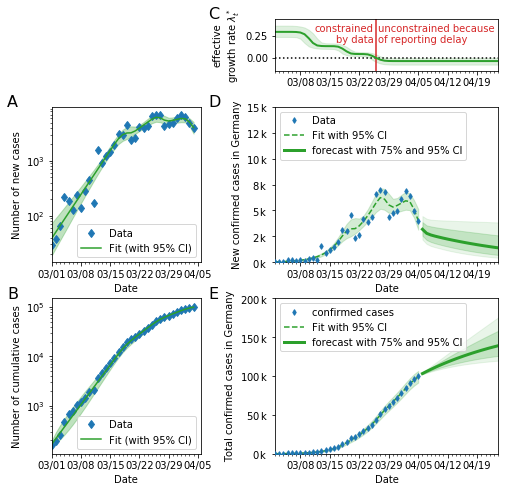

In [29]:
for trace, color, save_name in zip((trace_1step, trace_2steps,trace_3steps),
                                   ('tab:red', 'tab:orange', 'tab:green'),
                                   ('Fig_S1.png', 'Fig_3.png', 'Fig_S3.png')):

    fig, axes = plt.subplots(3,2, figsize=(8,8), gridspec_kw={'height_ratios': [1, 3,3],
                                                                'width_ratios': [2, 3]})
    #plt.locator_params(nbins=4)
    pos_letter = (-0.3, 1)
    titlesize = 16

    ax = axes[1][0]
    time_arr = np.arange(-len(cases_obs)+1, 0)
    mpl_dates = conv_time_to_mpl_dates(time_arr) + diff_data_sim + num_days_data
    ax.plot(mpl_dates, np.diff(cases_obs), 'd', markersize=6, label='Data')
    new_cases_past = trace.new_cases[:,:num_days_data]
    percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(new_cases_past, q=97.5, axis=0)
    ax.plot(mpl_dates, np.median(new_cases_past, axis=0),color=color, label='Fit (with 95% CI)')
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color=color)
    ax.set_yscale('log')
    ax.set_ylabel('Number of new cases')
    ax.set_xlabel('Date')
    ax.legend()
    ax.text(pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=titlesize)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(mpl_dates[0])

    #plt.savefig(path_to_save + 'check_new_cases.png', dpi=300)

    ax = axes[2][0]
    ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=6, label='Data')
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),color=color, label='Fit (with 95% CI)')
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color=color)
    ax.set_yscale('log')
    ax.set_ylabel('Number of cumulative cases')
    ax.set_xlabel('Date')
    ax.legend()
    ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=titlesize)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(mpl_dates[0])

    ax = axes[1][1]

    time1 = np.arange(-len(cases_obs)+2, 1)
    mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
    ax.plot(mpl_dates, np.diff(cases_obs), 'd', label='Data', markersize=4, color='tab:blue', 
                zorder=5)
    #ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, color='tab:blue', 
    #            zorder=6)

    percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    #ax.plot(mpl_dates, np.median(cum_cases, axis=0),color='tab:orange', linewidth=3)
    #ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')


    new_cases_past = trace.new_cases[:,:num_days_data]
    ax.plot(mpl_dates, np.median(new_cases_past, axis=0),'--',color=color, linewidth=1.5, label='Fit with 95% CI')
    percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(new_cases_past, q=97.5, axis=0)
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.2, color=color)

    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    cases_future = trace['new_cases'][:, num_days_data:].T
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*cases_obs[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
        np.percentile(cases_future, q=2.5, axis=-1),
        np.percentile(cases_future, q=97.5, axis=-1),
    )
    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label='forecast with 75% and 95% CI')
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.1, color=color)
    ax.fill_between(mpl_dates_fut[1:], np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
                    alpha=0.2, color=color)

    ax.set_xlabel('Date')
    ax.set_ylabel('New confirmed cases in Germany')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 15_000)
    # ax.legend(loc='lower left')
    #ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
    #ax.set_xlim(-28, 14)
    #ax.locator_params(axis="y", nbins=4)
    func_format = lambda num, _: "${:.0f}\,$k".format(num/1_000)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(start_date, end_date)
    ax.text(pos_letter[0], pos_letter[1], "D", transform=ax.transAxes, size=titlesize)


    ax = axes[2][1]

    time1 = np.arange(-len(cases_obs)+2, 1)
    mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
    ax.plot(mpl_dates, cases_obs[1:], 'd', label='confirmed cases', markersize=4, color='tab:blue', 
                zorder=5)
    #ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, color='tab:blue', 
    #            zorder=6)


    new_cases_past = trace.new_cases[:,:num_days_data]
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),'--',color=color, linewidth=1.5, label='Fit with 95% CI')
    percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.2, color=color)


    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    cases_future = np.cumsum(trace['new_cases'][:, num_days_data:].T, axis=0) + cases_obs[-1]
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*cases_obs[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
        np.percentile(cases_future, q=2.5, axis=-1),
        np.percentile(cases_future, q=97.5, axis=-1),
    )
    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label='forecast with 75% and 95% CI')
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.1, color=color)
    ax.fill_between(mpl_dates_fut[1:], np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
                    alpha=0.2, color=color)

    ax.set_xlabel('Date')
    ax.set_ylabel('Total confirmed cases in Germany')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 200_000)
    # ax.legend(loc='lower left')
    #ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
    #ax.set_xlim(-28, 14)
    #ax.locator_params(axis="y", nbins=4)
    func_format = lambda num, _: "${:.0f}\,$k".format(num/1_000)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(start_date, end_date)
    ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=titlesize)


    ax = axes[0][1]

    time = np.arange(-diff_to_0+1, -diff_to_0+num_days_sim+1)
    λ_t = trace['λ_t'][:, :]
    μ = trace['μ'][:,None]
    mpl_dates = conv_time_to_mpl_dates(time) + diff_data_sim + num_days_data

    ax.plot(mpl_dates, np.median(λ_t-μ, axis=0), color=color, linewidth=2)
    ax.fill_between(mpl_dates, np.percentile(λ_t-μ , q=2.5, axis=0),np.percentile(λ_t-μ, q=97.5, axis=0), alpha=0.15,
                    color=color)
    #ax.fill_between(mpl_dates, np.percentile(λ_t , q=12.5, axis=0),np.percentile(λ_t, q=87.5, axis=0), alpha=0.2,
    #                color=color)

    ax.set_ylabel('effective\ngrowth rate $\lambda_t^*$')
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
    ax.set_xticks([-28, -21, -14, -7, 0, 7, 14, 21, 28])
    #ax.set_xlim(-28, 14)
    ax.set_ylim(-0.15, 0.45)
    #ax.set_yticks([-0.2, 0, 0.2])
    #ax.set_aspect(15, adjustable="box")
    ax.hlines(0,start_date, end_date, linestyles=':')
    delay = matplotlib.dates.date2num(date_data_end) - np.percentile(trace_2steps.delay, q=75)
    ax.vlines(delay,-10, 10, linestyles='-', colors=['tab:red'])
    #ax.legend()
    ax.text(delay+0.5, 0.4, 'unconstrained because\nof reporting delay', color='tab:red', verticalalignment='top')
    ax.text(delay-0.5, 0.4, 'constrained\nby data', color='tab:red',horizontalalignment='right', verticalalignment='top')
    ax.text(pos_letter[0], pos_letter[1], "C", transform=ax.transAxes, size=titlesize)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(start_date, end_date)

    axes[0][0].set_visible(False)

    plt.subplots_adjust(wspace=0.4, hspace=.3)
    plt.savefig(path_to_save + save_name, dpi=300, bbox_inches='tight')


/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:219: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.DayLocator'>


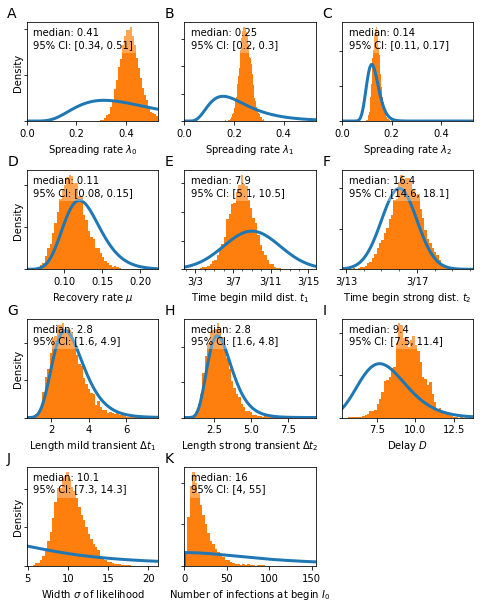

In [30]:
trace=trace_2steps

fig, axes = plt.subplots(4,3, figsize=(8,10))
#plt.locator_params(nbins=4)
pos_letter = (-0.15, 1.05)
size_letters=14
alpha_texbox=.3
font_text=10




limit_λ = (0,0.53)
ax = axes[0][0]
ax.hist(trace.λ_0, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_λ, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.4, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_λ)
ax.set_ylabel('Density')
ax.set_xlabel('Spreading rate $\lambda_0$')
text = print_median_CI(trace.λ_0, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=size_letters)


ax = axes[0][1]
ax.hist(trace.λ_1, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_λ, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.2, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_λ)
ax.set_xlabel('Spreading rate $\lambda_1$')
text = print_median_CI(trace.λ_1, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=size_letters)

ax = axes[0][2]
ax.hist(trace.λ_2, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_λ, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_λ)
ax.set_xlabel('Spreading rate $\lambda_2$')
text = print_median_CI(trace.λ_2, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "C", transform=ax.transAxes, size=size_letters)

ax = axes[1][0]
ax.hist(trace.μ, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Recovery rate $\mu$')
text = print_median_CI(trace.μ, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "D", transform=ax.transAxes, size=size_letters)

diff_to_0 = num_days_data + diff_data_sim 



dates_mild = conv_time_to_mpl_dates(trace.mild_dist_begin)

ax = axes[1][1]
ax.hist(dates_mild, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=conv_time_to_mpl_dates([prior_day_mild_dist_begin])[0], scale=3), 
        label='Prior',color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Time begin mild dist. $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))

ax = axes[1][2]
dates_strong = conv_time_to_mpl_dates(trace.strong_dist_begin)

ax.hist(dates_strong, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=conv_time_to_mpl_dates([prior_day_strong_dist_begin])[0], scale=1), 
        label='Prior',color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Time begin strong dist. $t_2$')
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))

ax = axes[2][0]
ax.hist(trace.transient_mild, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Length mild transient $\Delta t_1$')
text = print_median_CI(trace.transient_mild, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G", transform=ax.transAxes, size=size_letters)


ax = axes[2][1]
ax.hist(trace.transient_strong, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Length strong transient $\Delta t_2$')
text = print_median_CI(trace.transient_strong, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)

ax = axes[2][2]
ax.hist(trace.delay, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=8, s=0.2), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Delay $D$')
text = print_median_CI(trace.delay, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=size_letters)


ax = axes[3][0]
ax.hist(trace.σ_obs, bins=50, color='tab:orange', density=True, label='Posterior')
ax.set_ylabel('Density')
ax.set_xlabel("Width $\sigma$ of likelihood")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.σ_obs, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "J", transform=ax.transAxes, size=size_letters)


ax = axes[3][1]
ax.hist(trace.I_begin, bins=50, color='tab:orange', density=True, label='Posterior')
ax.set_xlabel('Number of infections at begin $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = print_median_CI(trace.I_begin, prec=0)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "K", transform=ax.transAxes, size=size_letters)
plt.subplots_adjust(hspace=0.5)
#plt.tight_layout()

ax = axes[3][2]
ax.set_visible(False)

for ax_row in axes:
    for ax in ax_row:
        ax.tick_params(labelleft=False)   
        ax.locator_params(nbins=4) 


plt.savefig(path_to_save + 'Fig_4.png', dpi=300)

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:166: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.DayLocator'>


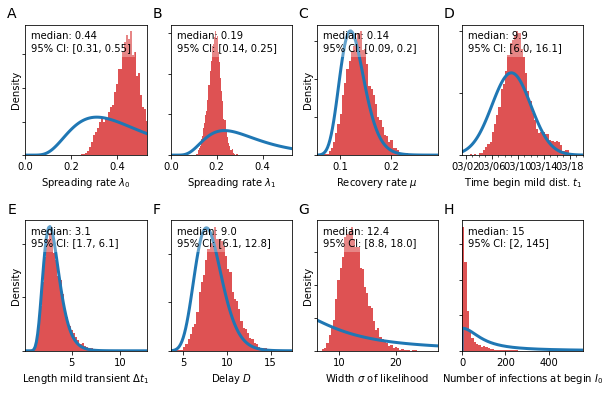

In [31]:
trace=trace_1step
alpha=0.8
color='tab:red'

fig, axes = plt.subplots(2,4, figsize=(10,6))
#plt.locator_params(nbins=4)
pos_letter = (-0.15, 1.05)
size_letters=14
alpha_texbox=.3
font_text=10

limit_λ = (0,0.53)
ax = axes[0][0]
ax.hist(trace.λ_0, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_λ, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.4, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_λ)
ax.set_ylabel('Density')
ax.set_xlabel('Spreading rate $\lambda_0$')
text = print_median_CI(trace.λ_0, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=size_letters)


ax = axes[0][1]
ax.hist(trace.λ_1, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_λ, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.3, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_λ)
ax.set_xlabel('Spreading rate $\lambda_1$')
text = print_median_CI(trace.λ_1, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=size_letters)


ax = axes[0][2]
ax.hist(trace.μ, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Recovery rate $\mu$')
text = print_median_CI(trace.μ, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "C", transform=ax.transAxes, size=size_letters)

diff_to_0 = num_days_data + diff_data_sim 



dates_mild = conv_time_to_mpl_dates(trace.mild_dist_begin)

ax = axes[0][3]
ax.hist(dates_mild, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=conv_time_to_mpl_dates([prior_day_mild_dist_begin])[0], scale=3), 
        label='Prior',color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Time begin mild dist. $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "D", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))



ax = axes[1][0]
ax.hist(trace.transient_mild, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Length mild transient $\Delta t_1$')
text = print_median_CI(trace.transient_mild, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=size_letters)


ax = axes[1][1]
ax.hist(trace.delay, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=8, s=0.2), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Delay $D$')
text = print_median_CI(trace.delay, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)


ax = axes[1][2]
ax.hist(trace.σ_obs, bins=50, color=color, density=True, alpha=alpha,label='Posterior')
ax.set_ylabel('Density')
ax.set_xlabel("Width $\sigma$ of likelihood")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.σ_obs, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G", transform=ax.transAxes, size=size_letters)


ax = axes[1][3]
ax.hist(trace.I_begin, bins=50, color=color, density=True,alpha=alpha, label='Posterior')
ax.set_xlabel('Number of infections at begin $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = print_median_CI(trace.I_begin, prec=0)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)
plt.subplots_adjust(hspace=0.5)
#plt.tight_layout()


for ax_row in axes:
    for ax in ax_row:
        ax.tick_params(labelleft=False)   
        ax.locator_params(nbins=4) 


plt.savefig(path_to_save + 'Fig_S2.png', dpi=300, bbox_inches='tight')

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:274: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.DayLocator'>


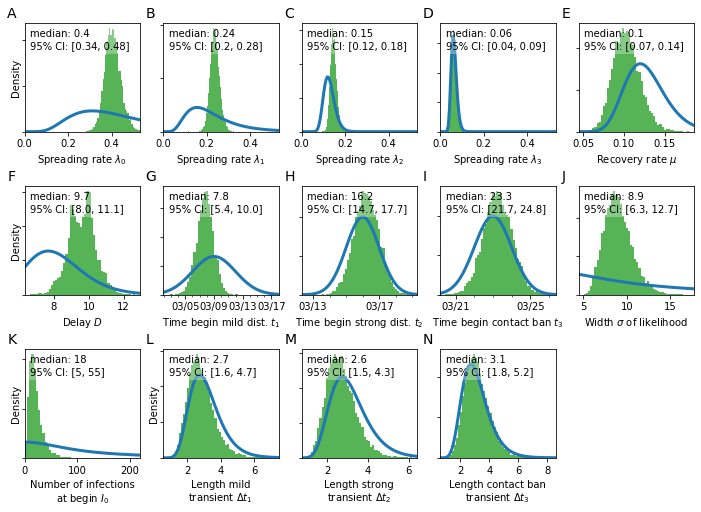

In [32]:
trace=trace_3steps

color='tab:green'
alpha=0.8

fig, axes = plt.subplots(3,5, figsize=(12,8))
#plt.locator_params(nbins=4)
pos_letter = (-0.15, 1.05)
size_letters=14
alpha_texbox=.3
font_text=10

limit_λ = (0,0.53)
ax = axes[0][0]
ax.hist(trace.λ_0, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_λ, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.4, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_λ)
ax.set_ylabel('Density')
ax.set_xlabel('Spreading rate $\lambda_0$')
text = print_median_CI(trace.λ_0, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=size_letters)


ax = axes[0][1]
ax.hist(trace.λ_1, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_λ, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.2, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_λ)
ax.set_xlabel('Spreading rate $\lambda_1$')
text = print_median_CI(trace.λ_1, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=size_letters)

ax = axes[0][2]
ax.hist(trace.λ_2, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_λ, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_λ)
ax.set_xlabel('Spreading rate $\lambda_2$')
text = print_median_CI(trace.λ_2, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "C", transform=ax.transAxes, size=size_letters)

ax = axes[0][3]
ax.hist(trace.λ_3, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limit_λ, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8/2, s=0.2), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limit_λ)
ax.set_xlabel('Spreading rate $\lambda_3$')
text = print_median_CI(trace.λ_3, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "D", transform=ax.transAxes, size=size_letters)

ax = axes[0][4]
ax.hist(trace.μ, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Recovery rate $\mu$')
text = print_median_CI(trace.μ, prec=2)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=size_letters)

diff_to_0 = num_days_data + diff_data_sim 


ax = axes[1][0]
ax.hist(trace.delay, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=8, s=0.2), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Delay $D$')
ax.set_ylabel('Density')
text = print_median_CI(trace.delay, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)

dates_mild = conv_time_to_mpl_dates(trace.mild_dist_begin)

ax = axes[1][1]
ax.hist(dates_mild, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=conv_time_to_mpl_dates([prior_day_mild_dist_begin])[0], scale=3), 
        label='Prior',color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Time begin mild dist. $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))

ax = axes[1][2]
dates_strong = conv_time_to_mpl_dates(trace.strong_dist_begin)

ax.hist(dates_strong, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=conv_time_to_mpl_dates([prior_day_strong_dist_begin])[0], scale=1), 
        label='Prior',color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Time begin strong dist. $t_2$')
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))

ax = axes[1][3]
dates_3rd = conv_time_to_mpl_dates(trace.third_scenario_begin)

ax.hist(dates_3rd, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=conv_time_to_mpl_dates([prior_day_3rd_scenario_begin])[0], scale=1), 
        label='Prior',color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Time begin contact ban $t_3$')
text = print_median_CI(dates_3rd - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))


ax = axes[1][4]
ax.hist(trace.σ_obs, bins=50, color=color, density=True, label='Posterior',alpha=alpha)
ax.set_xlabel("Width $\sigma$ of likelihood")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.σ_obs, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "J", transform=ax.transAxes, size=size_letters)

ax = axes[2][0]
ax.hist(trace.I_begin, bins=50, color=color, density=True, alpha=alpha,label='Posterior')
ax.set_xlabel('Number of infections\nat begin $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlim(0)
text = print_median_CI(trace.I_begin, prec=0)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "K", transform=ax.transAxes, size=size_letters)
plt.subplots_adjust(hspace=0.5)

ax = axes[2][1]
ax.hist(trace.transient_mild, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Length mild\ntransient $\Delta t_1$')
text = print_median_CI(trace.transient_mild, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "L", transform=ax.transAxes, size=size_letters)




ax = axes[2][2]
ax.hist(trace.transient_strong, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Length strong\ntransient $\Delta t_2$')
text = print_median_CI(trace.transient_strong, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "M", transform=ax.transAxes, size=size_letters)

ax = axes[2][3]
ax.hist(trace.transient_third_scenario, bins=50, density=True, color=color,alpha=alpha,
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Length contact ban\ntransient $\Delta t_3$')
text = print_median_CI(trace.transient_third_scenario, prec=1)
ax.text(0.05, 0.95, text, horizontalalignment='left',
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "N", transform=ax.transAxes, size=size_letters)


#plt.tight_layout()

ax = axes[2][4]
ax.set_visible(False)

for ax_row in axes:
    for ax in ax_row:
        ax.tick_params(labelleft=False)   
        ax.locator_params(nbins=4) 


plt.savefig(path_to_save + 'Fig_S4.png', dpi=300, bbox_inches='tight')

In [33]:
print('\n1 step model\n')
use_2nd_step.set_value(0.0)
use_3rd_step.set_value(0.0)
print(pm.loo(trace_1step, model))

print('\n2 steps model\n')
use_2nd_step.set_value(1.0)
use_3rd_step.set_value(0.0)
print(pm.loo(trace_2steps, model))

print('\n3 steps model\n')
use_2nd_step.set_value(1.0)
use_3rd_step.set_value(1.0)
print(pm.loo(trace_3steps, model))


1 step model

Computed from 9000 by 35 log-likelihood matrix

       Estimate       SE
IC_loo   560.51    18.32
p_loo     12.12        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       34   97.1%
 (0.5, 0.7]   (ok)          1    2.9%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


2 steps model

Computed from 9000 by 35 log-likelihood matrix

       Estimate       SE
IC_loo   539.63    16.27
p_loo      8.66        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       34   97.1%
 (0.5, 0.7]   (ok)          1    2.9%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


3 steps model

Computed from 9000 by 35 log-likelihood matrix

       Estimate       SE
IC_loo   531.12    16.06
p_loo      8.98        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       35  100.0%
 (0.5, 0.7]   (ok)